In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, precision_recall_curve, auc, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import os

import torch

import warnings
warnings.filterwarnings("ignore") 

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cuda


In [3]:
## Load lending club data 
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/Dataset_with_grade.csv"
data = pd.read_csv(data_path, low_memory=False)

In [4]:
data.head()

,last_fico_range_high,mo_sin_old_rev_tl_op,int_rate,annual_inc,dti,zip_code,installment,fico_range_low,total_rev_hi_lim,avg_cur_bal,...,revol_util,revol_bal,total_acc,loan_status,grade,total_pymnt,total_pymnt_inv,loan_amnt,credit_history_years,term_months
0,704.0,180.629118,0.1065,24000.0,27.65,860.0,162.87,735.0,33823.97164,13588.188308,...,0.837,13648.0,9.0,0,B,5863.155187,5833.84,5000.0,26,36
1,499.0,180.629118,0.1527,30000.0,1.00,309.0,59.83,740.0,33823.97164,13588.188308,...,0.094,1687.0,4.0,1,C,1014.530000,1014.53,2500.0,12,60
2,739.0,180.629118,0.1596,12252.0,8.72,606.0,84.33,735.0,33823.97164,13588.188308,...,0.985,2956.0,10.0,0,C,3005.666844,3005.67,2400.0,10,36
3,604.0,180.629118,0.1349,49200.0,20.00,917.0,339.31,690.0,33823.97164,13588.188308,...,0.210,5598.0,37.0,0,C,12231.890000,12231.89,10000.0,15,36
4,684.0,180.629118,0.1269,80000.0,17.94,972.0,67.79,695.0,33823.97164,13588.188308,...,0.539,27783.0,38.0,0,B,4066.908161,4066.91,3000.0,15,60


In [5]:
data_original = data.copy()

In [6]:
return_cols = ['total_pymnt_inv', 'loan_amnt']

for col in return_cols:
    print(f"before {col} dropna : {len(data_original[col])}")
    data_original[col] = data_original[col].fillna(data_original[col].mean())
    print(f"After {col} dropna : {len(data_original[col])}")

before total_pymnt_inv dropna : 1860764
After total_pymnt_inv dropna : 1860764
before loan_amnt dropna : 1860764
After loan_amnt dropna : 1860764


In [7]:
data_original['annualized_return'] = (data_original['total_pymnt_inv'] / data_original['loan_amnt']) ** (12 / data_original['term_months']) - 1
data_original['return'] = (data_original['total_pymnt_inv']-data_original['loan_amnt'])/data_original['loan_amnt']

data_original['annualized_return_percent'] = data_original['annualized_return'] * 100
data_original['return_percent'] = data_original['return']*100

data_original[['loan_status','annualized_return_percent', 'return_percent']].head()

,loan_status,annualized_return_percent,return_percent
0,0,5.275708,16.676800
1,1,-16.504133,-59.418800
2,0,7.789556,25.236250
3,0,6.945994,22.318900
4,0,6.274400,35.563667


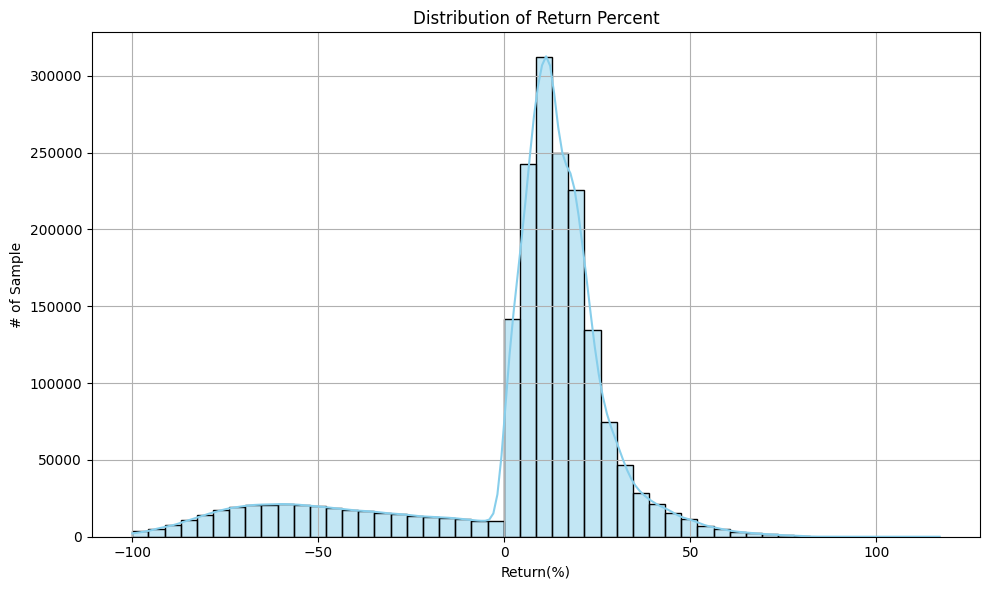

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=data_original, x='return_percent', bins=50, kde=True, color='skyblue')
plt.title('Distribution of Return Percent')
plt.xlabel('Return(%)')
plt.ylabel('# of Sample')
plt.grid(True)
plt.tight_layout()
plt.show()

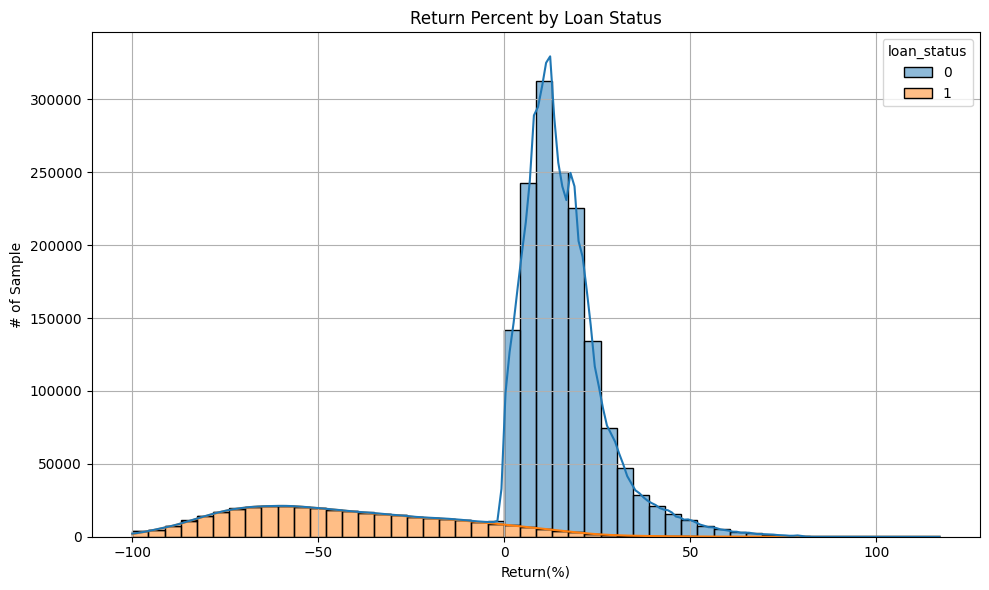

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data_original, x='return_percent', hue='loan_status', bins=50, kde=True, multiple='stack')
plt.title('Return Percent by Loan Status')
plt.xlabel('Return(%)')
plt.ylabel('# of Sample')
plt.grid(True)
plt.tight_layout()
plt.show()

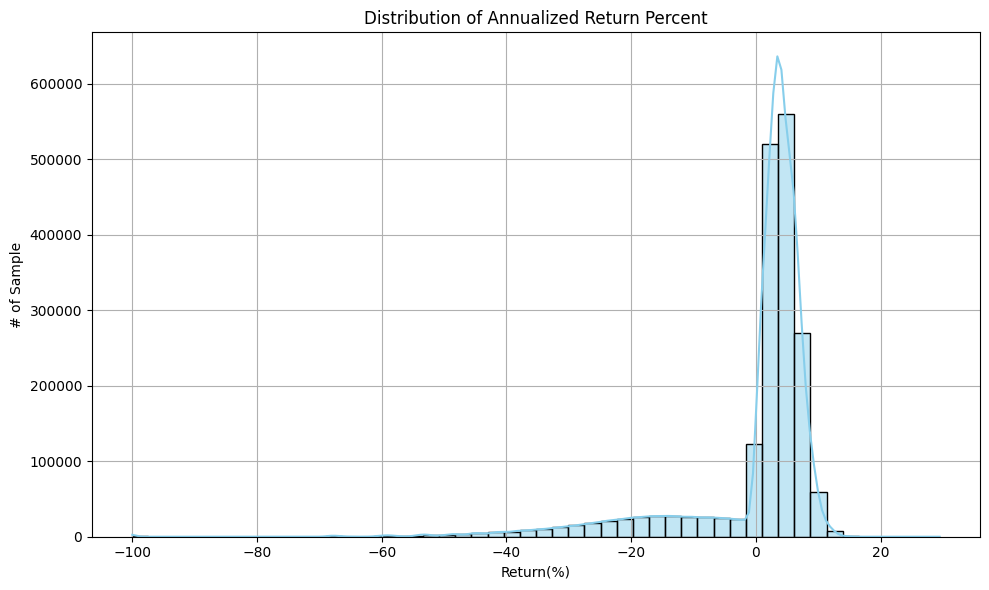

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=data_original, x='annualized_return_percent', bins=50, kde=True, color='skyblue')
plt.title('Distribution of Annualized Return Percent')
plt.xlabel('Return(%)')
plt.ylabel('# of Sample')
plt.grid(True)
plt.tight_layout()
plt.show()

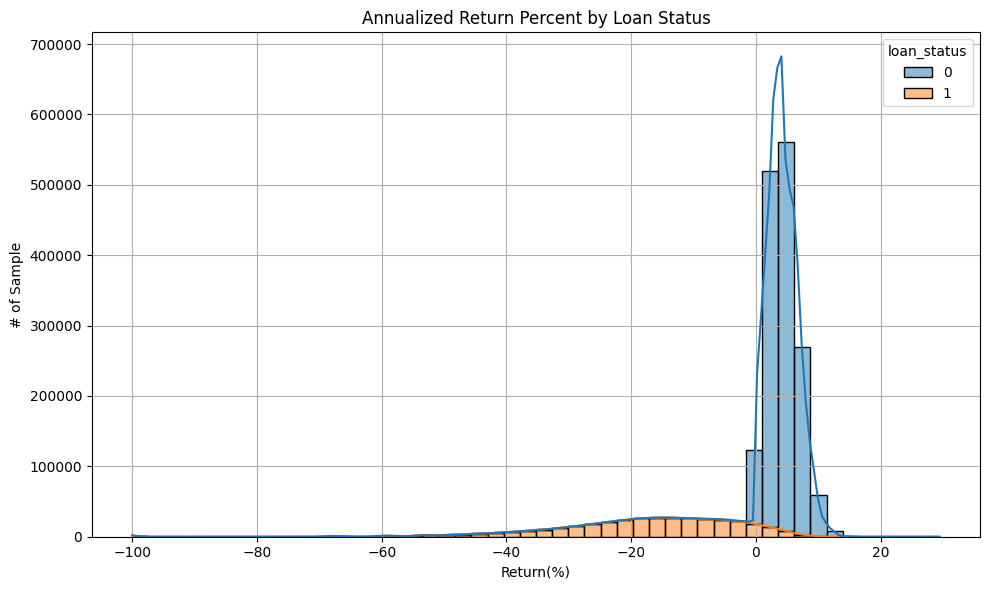

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data_original, x='annualized_return_percent', hue='loan_status', bins=50, kde=True, multiple='stack')
plt.title('Annualized Return Percent by Loan Status')
plt.xlabel('Return(%)')
plt.ylabel('# of Sample')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
#0.837 -> 83.7
def converting_cat_to_num(x):
    return float(x*100)

# Converting numerically data stored as categorical
data_original['int_rate'] = data_original['int_rate'].map(converting_cat_to_num)

print("Successfully converted!")
display(data_original[['int_rate']].head())

Successfully converted!


,int_rate
0,10.65
1,15.27
2,15.96
3,13.49
4,12.69


In [18]:
# grade별로 그룹화하여 요약 통계 계산
grade_summary = data_original.groupby("grade").agg(
    Loan_Amount=("loan_amnt", "sum"),  # 필요 시 loan_amnt도 포함 가능
    Interest_Rate=("int_rate", "mean"),
    Historical_Return=("return_percent", "mean"),
    Std_Deviation=("return_percent", "std")
).reset_index()

# 보기 좋게 소수점 2자리로 반올림
grade_summary = grade_summary.round({
    "Loan_Amount": 2,
    "Interest_Rate": 2,
    "Historical_Return": 2,
    "Std_Deviation": 2
})

# 전체 평균행 추가 (All row)
all_row = pd.DataFrame({
    "grade": ["All"],
    "Loan_Amount": [data_original["loan_amnt"].sum()],
    "Interest_Rate": [data_original["int_rate"].mean()],
    "Historical_Return": [data_original["return_percent"].mean()],
    "Std_Deviation": [data_original["return_percent"].std()]
}).round(2)

In [19]:
# All 행 추가
grade_summary = pd.concat([grade_summary, all_row], ignore_index=True)

# grade 컬럼 순서 정렬 (A~G, All)
grade_order = sorted(data_original["grade"].unique().tolist()) + ["All"]
grade_summary["grade"] = pd.Categorical(grade_summary["grade"], categories=grade_order, ordered=True)
grade_summary = grade_summary.sort_values("grade").reset_index(drop=True)

# 결과 출력
print(grade_summary)

  grade   Loan_Amount  Interest_Rate  Historical_Return  Std_Deviation
0     A  4.876723e+09           7.13               4.60          15.89
1     B  7.404450e+09          10.69               5.55          22.86
2     C  7.642996e+09          14.12               4.34          30.34
3     D  4.253599e+09          18.12               2.78          36.82
4     E  2.040035e+09          21.54               3.14          42.16
5     F  7.085681e+08          25.22               1.68          47.30
6     G  2.196558e+08          27.98              -2.77          49.80
7   All  2.714603e+10          13.17               4.34          28.88


In [20]:
import pandas as pd

# 복사본 생성
df = grade_summary.copy()

# F, G 행만 필터링해서 합산
fg_combined = df[df['grade'].isin(['F', 'G'])].copy()

# 합산 후 F+G로 새 행 만들기
fg_row = pd.DataFrame({
    'grade': ['F+G'],
    'Loan_Amount': [fg_combined['Loan_Amount'].sum()],
    'Interest_Rate': [(
        fg_combined['Interest_Rate'] * fg_combined['Loan_Amount']
    ).sum() / fg_combined['Loan_Amount'].sum()],
    'Historical_Return': [(
        fg_combined['Historical_Return'] * fg_combined['Loan_Amount']
    ).sum() / fg_combined['Loan_Amount'].sum()],
    'Std_Deviation': [(
        fg_combined['Std_Deviation'] * fg_combined['Loan_Amount']
    ).sum() / fg_combined['Loan_Amount'].sum()]  # 근사치 평균 (정확한 합산 std는 별도 방식 필요)
})

# 기존 F, G 제거하고 F+G 추가
df = df[~df['grade'].isin(['F', 'G'])]
df = pd.concat([df, fg_row], ignore_index=True)

# grade 순서 재정렬
grade_order = ['A', 'B', 'C', 'D', 'E', 'F+G', 'All']
df['grade'] = pd.Categorical(df['grade'], categories=grade_order, ordered=True)
df = df.sort_values('grade').reset_index(drop=True)

print(df)


  grade   Loan_Amount  Interest_Rate  Historical_Return  Std_Deviation
0     A  4.876723e+09       7.130000           4.600000      15.890000
1     B  7.404450e+09      10.690000           5.550000      22.860000
2     C  7.642996e+09      14.120000           4.340000      30.340000
3     D  4.253599e+09      18.120000           2.780000      36.820000
4     E  2.040035e+09      21.540000           3.140000      42.160000
5   F+G  9.282239e+08      25.873129           0.626948      47.891602
6   All  2.714603e+10      13.170000           4.340000      28.880000


In [4]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, train_size=0.8, test_size=0.2, random_state=42, stratify=data_y)

train_data = pd.concat([X_train,y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis = 1)

### Test data 수익률, grade별 수익률, return 값 확인

In [5]:
test_data['annualized_return'] = (test_data['total_pymnt_inv'] / test_data['loan_amnt']) ** (12 / test_data['term_months']) - 1
test_data['return'] = (test_data['total_pymnt_inv']-test_data['loan_amnt'])/test_data['loan_amnt']

test_data['annualized_return_percent'] = test_data['annualized_return'] * 100
test_data['return_percent'] = test_data['return']*100

test_data[['loan_status','annualized_return_percent', 'return_percent']].head()

,loan_status,annualized_return_percent,return_percent
749596,0,6.825250,21.905067
662378,0,4.681522,25.704300
1126565,0,1.089618,3.304600
520145,0,2.220230,6.809667
819148,0,3.905747,12.180846


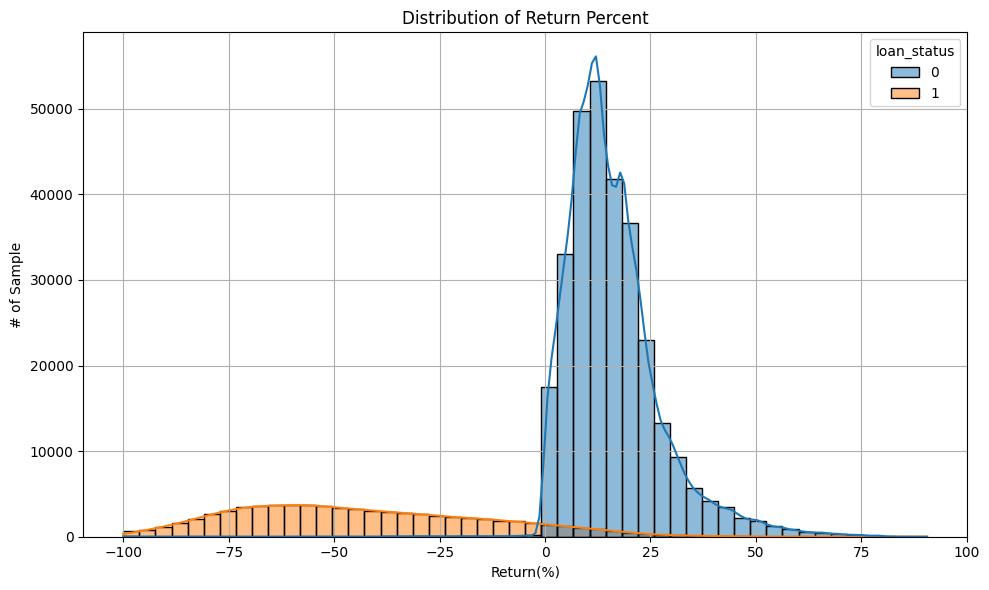

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=test_data, x='return_percent', hue='loan_status',bins=50, kde=True, color='skyblue')
plt.title('Distribution of Return Percent')
plt.xlabel('Return(%)')
plt.ylabel('# of Sample')
plt.grid(True)
plt.tight_layout()
plt.show()

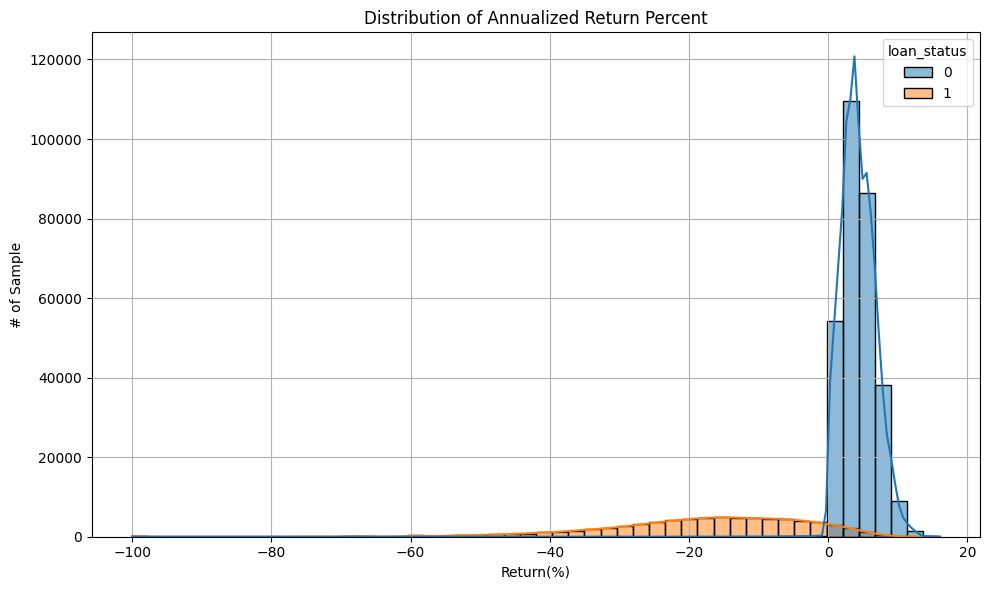

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=test_data, x='annualized_return_percent', hue='loan_status',bins=50, kde=True, color='skyblue')
plt.title('Distribution of Annualized Return Percent')
plt.xlabel('Return(%)')
plt.ylabel('# of Sample')
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
#0.837 -> 83.7
def converting_cat_to_num(x):
    return float(x*100)

# Converting numerically data stored as categorical
test_data['int_rate'] = test_data['int_rate'].map(converting_cat_to_num)

print("Successfully converted!")
display(test_data[['int_rate']].head())

Successfully converted!


,int_rate
749596,13.35
662378,24.50
1126565,9.99
520145,7.21
819148,7.62


In [8]:
# grade별로 그룹화하여 요약 통계 계산
grade_summary = test_data.groupby("grade").agg(
    Loan_Amount=("loan_amnt", "sum"),  # 필요 시 loan_amnt도 포함 가능
    Interest_Rate=("int_rate", "mean"),
    Historical_Return=("annualized_return_percent", "mean"),
    Std_Deviation=("annualized_return_percent", "std")
).reset_index()

# 보기 좋게 소수점 2자리로 반올림
grade_summary = grade_summary.round({
    "Loan_Amount": 2,
    "Interest_Rate": 2,
    "Historical_Return": 2,
    "Std_Deviation": 2
})

# 전체 평균행 추가 (All row)
all_row = pd.DataFrame({
    "grade": ["All"],
    "Loan_Amount": [test_data["loan_amnt"].sum()],
    "Interest_Rate": [test_data["int_rate"].mean()],
    "Historical_Return": [test_data["annualized_return_percent"].mean()],
    "Std_Deviation": [test_data["annualized_return_percent"].std()]
}).round(2)

In [9]:
# All 행 추가
grade_summary = pd.concat([grade_summary, all_row], ignore_index=True)

# grade 컬럼 순서 정렬 (A~G, All)
grade_order = sorted(test_data["grade"].unique().tolist()) + ["All"]
grade_summary["grade"] = pd.Categorical(grade_summary["grade"], categories=grade_order, ordered=True)
grade_summary = grade_summary.sort_values("grade").reset_index(drop=True)

# 결과 출력
print(grade_summary)

  grade   Loan_Amount  Interest_Rate  Historical_Return  Std_Deviation
0     A  9.752734e+08           7.13               0.95           7.81
1     B  1.474283e+09          10.70               0.84           9.78
2     C  1.528565e+09          14.12              -0.11          11.71
3     D  8.543094e+08          18.11              -1.22          13.67
4     E  4.088939e+08          21.56              -1.59          13.68
5     F  1.456266e+08          25.17              -1.80          13.49
6     G  4.290082e+07          27.94              -4.04          15.67
7   All  5.429852e+09          13.18               0.05          11.13


In [10]:
import pandas as pd

# 복사본 생성
df = grade_summary.copy()

# F, G 행만 필터링해서 합산
fg_combined = df[df['grade'].isin(['F', 'G'])].copy()

# 합산 후 F+G로 새 행 만들기
fg_row = pd.DataFrame({
    'grade': ['F+G'],
    'Loan_Amount': [fg_combined['Loan_Amount'].sum()],
    'Interest_Rate': [(
        fg_combined['Interest_Rate'] * fg_combined['Loan_Amount']
    ).sum() / fg_combined['Loan_Amount'].sum()],
    'Historical_Return': [(
        fg_combined['Historical_Return'] * fg_combined['Loan_Amount']
    ).sum() / fg_combined['Loan_Amount'].sum()],
    'Std_Deviation': [(
        fg_combined['Std_Deviation'] * fg_combined['Loan_Amount']
    ).sum() / fg_combined['Loan_Amount'].sum()]  # 근사치 평균 (정확한 합산 std는 별도 방식 필요)
})

# 기존 F, G 제거하고 F+G 추가
df = df[~df['grade'].isin(['F', 'G'])]
df = pd.concat([df, fg_row], ignore_index=True)

# grade 순서 재정렬
grade_order = ['A', 'B', 'C', 'D', 'E', 'F+G', 'All']
df['grade'] = pd.Categorical(df['grade'], categories=grade_order, ordered=True)
df = df.sort_values('grade').reset_index(drop=True)

print(df)


  grade   Loan_Amount  Interest_Rate  Historical_Return  Std_Deviation
0     A  9.752734e+08       7.130000           0.950000       7.810000
1     B  1.474283e+09      10.700000           0.840000       9.780000
2     C  1.528565e+09      14.120000          -0.110000      11.710000
3     D  8.543094e+08      18.110000          -1.220000      13.670000
4     E  4.088939e+08      21.560000          -1.590000      13.680000
5   F+G  1.885275e+08      25.800334          -2.309729      13.986075
6   All  5.429852e+09      13.180000           0.050000      11.130000


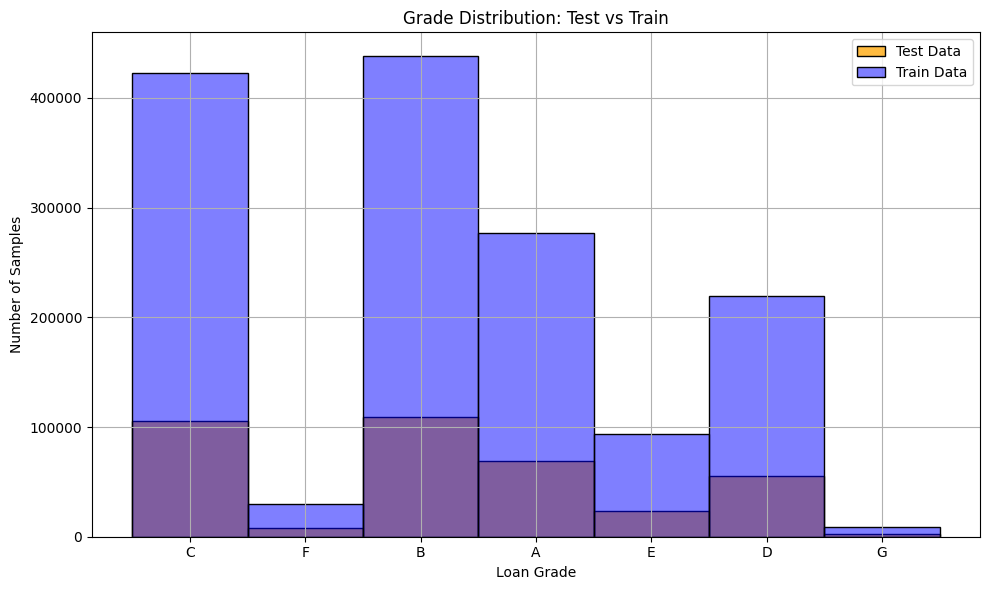

In [21]:
## test_data 각 Grade 분포 및 Train data 각 Grade 분포 비교
plt.figure(figsize=(10, 6))
sns.histplot(data=test_data, x="grade", stat="count", discrete=True, label="Test Data", color="orange")
sns.histplot(data=train_data, x="grade", stat="count", discrete=True, label="Train Data", color="blue", alpha=0.5)

# 2. 그래프 설정
plt.title("Grade Distribution: Test vs Train")
plt.xlabel("Loan Grade")
plt.ylabel("Number of Samples")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
## Loan_status로 분리
train_majority = train_data[train_data['loan_status'] == 0]
train_minority = train_data[train_data['loan_status'] == 1]

test_majority = test_data[test_data['loan_status'] == 0]
test_minority = test_data[test_data['loan_status'] == 1]

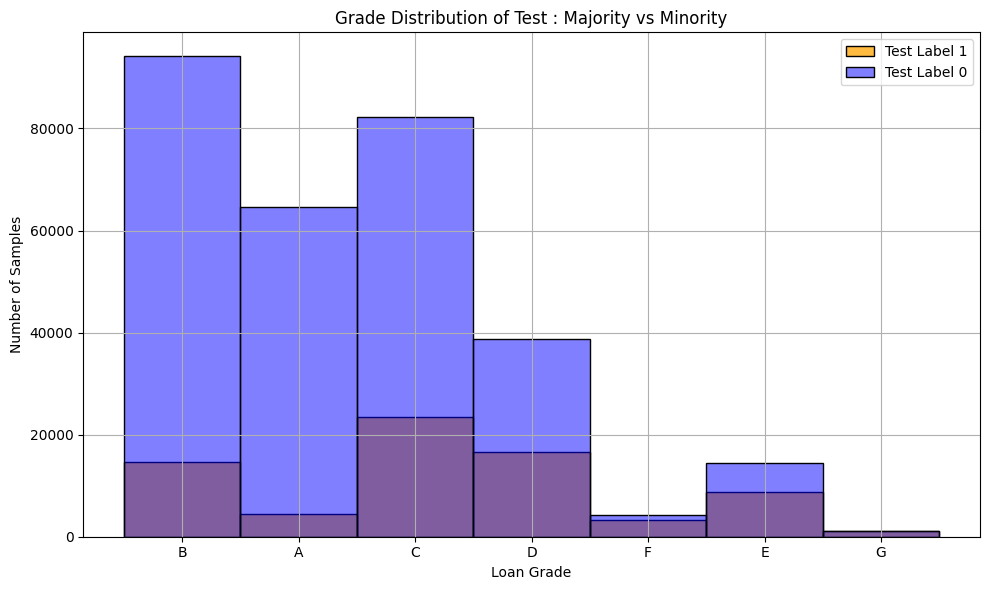

In [27]:
## test_data 각 Grade 분포 Loan_status class 분리리
plt.figure(figsize=(10, 6))
sns.histplot(data=test_minority, x="grade", stat="count", discrete=True, label="Test Label 1", color="orange")
sns.histplot(data=test_majority, x="grade", stat="count", discrete=True, label="Test Label 0", color="blue", alpha=0.5)

# 2. 그래프 설정
plt.title("Grade Distribution of Test : Majority vs Minority")
plt.xlabel("Loan Grade")
plt.ylabel("Number of Samples")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

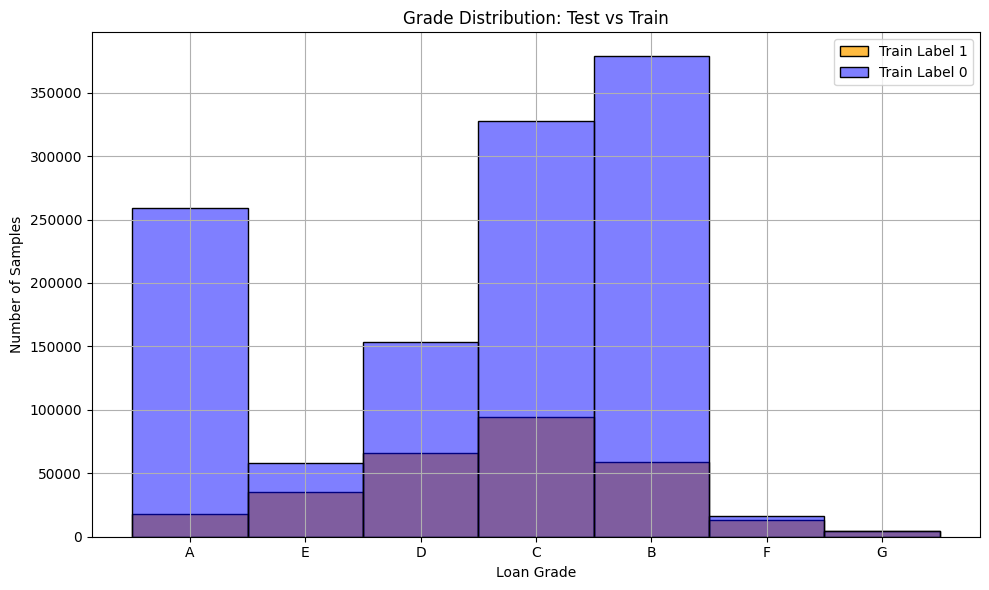

In [26]:
## Train_data 각 Grade 분포 Loan_status class 분리리
plt.figure(figsize=(10, 6))
sns.histplot(data=train_minority, x="grade", stat="count", discrete=True, label="Train Label 1", color="orange")
sns.histplot(data=train_majority, x="grade", stat="count", discrete=True, label="Train Label 0", color="blue", alpha=0.5)

# 2. 그래프 설정
plt.title("Grade Distribution: Test vs Train")
plt.xlabel("Loan Grade")
plt.ylabel("Number of Samples")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
test_minority_A = test_minority[test_minority['grade'] == 'A']

In [34]:
test_minority_A.columns

Index(['last_fico_range_high', 'mo_sin_old_rev_tl_op', 'int_rate',
       'annual_inc', 'dti', 'zip_code', 'installment', 'fico_range_low',
       'total_rev_hi_lim', 'avg_cur_bal', 'bc_open_to_buy', 'revol_util',
       'revol_bal', 'total_acc', 'grade', 'total_pymnt', 'total_pymnt_inv',
       'loan_amnt', 'credit_history_years', 'term_months', 'loan_status',
       'annualized_return', 'return', 'annualized_return_percent',
       'return_percent'],
      dtype='object')

In [35]:
drop_feature = ['grade', 'total_pymnt', 'total_pymnt_inv','loan_amnt',
                'term_months','annualized_return','return','annualized_return_percent',
                'return_percent']

test_minority_A = test_minority_A.drop(columns=drop_feature)

test_minority_A.columns

Index(['last_fico_range_high', 'mo_sin_old_rev_tl_op', 'int_rate',
       'annual_inc', 'dti', 'zip_code', 'installment', 'fico_range_low',
       'total_rev_hi_lim', 'avg_cur_bal', 'bc_open_to_buy', 'revol_util',
       'revol_bal', 'total_acc', 'credit_history_years', 'loan_status'],
      dtype='object')

In [40]:
test_minority_A['int_rate'].head()

346457     0.735
1308342    0.789
271761     0.735
208582     0.662
528418     0.746
Name: int_rate, dtype: float64

In [ ]:
#0.837 -> 83.7
def converting_cat_to_num(x):
    return float(x/10)

# Converting numerically data stored as categorical
test_minority_A['int_rate'] = test_minority_A['int_rate'].map(converting_cat_to_num)

print("Successfully converted!")
display(test_minority_A[['int_rate']].head())

Successfully converted!


,int_rate
346457,0.735
1308342,0.789
271761,0.735
208582,0.662
528418,0.746


In [42]:
test_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"
test_minority_A.to_csv(path_or_buf=test_path+"test_A.csv", index=False)